In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults, ARIMAResults
from matplotlib.pyplot import acorr
import sys
print sys.version
import Quandl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
%pylab inline

2.7.11 (default, Dec  5 2015, 14:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Dataset used - Chinese SUV Sales, January 2005 to February 2016 (most recent)

Source - Quandl, Chinese Association of Automobile Manufacturers (CAAM)

Period - Monthly

Unit - 10,000 units


In [2]:
#df = Quandl.get("DY2/I3120000016", authtoken="c9bPurJzuxVu2somxtKZ")
df = pd.read_csv('CAAM_suv_sales.csv')
#df.rename(columns = {'End Date':'date'}, inplace = True)
#df.date = pd.to_datetime(df.date)
#pd.to_datetime(df.Year + df.Month + df.Day, format="%d%m%Y")
#df.head()
df['date'] = pd.to_datetime(df['End Date'])
type(df['date'])

pandas.core.series.Series

In [3]:
# g = pd.TimeGrouper('M')
# avg = df.groupby(g).mean()
# df['avg'] = df.groupby(g).transform(lambda x: x-x.mean())
# df.head()

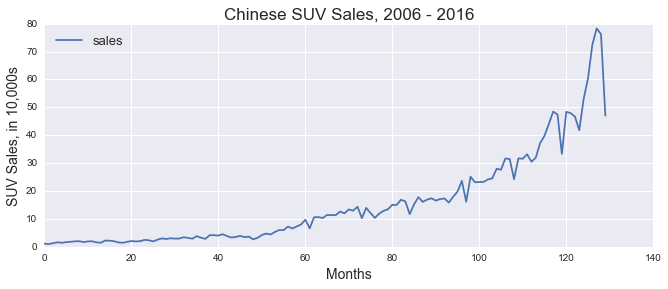

In [4]:
fig, ax = plt.subplots(figsize=(24,4))

plt.subplot(121)
plt.plot(df.sales)
plt.title('Chinese SUV Sales, 2006 - 2016', fontsize = 17)
plt.xlabel('Months', fontsize = 14)
plt.ylabel('SUV Sales, in 10,000s', fontsize = 14)
plt.legend(loc = 2, fontsize = 13)

In [5]:
# estimate what the last value lost from differencing should be
(47.02/76.23)*.483182

0.29803512580348945

In [6]:
# given the increasing variance, mean, and obvious seasonality, we need to adjust our data a bit
# first, we will take the logs to account for the increasing mean
df['log_sales'] = log(df.sales)
df['diff_log_sales'] = df.log_sales - df.log_sales.shift(periods = -1)
df.tail()

,End Date,Month,Day,Year,sales,date,log_sales,diff_log_sales
125,10/31/15,10,31,2015,60.23,2015-10-31,4.098171,-0.183068
126,11/30/15,11,30,2015,72.33,2015-11-30,4.281239,-0.079053
127,12/31/15,12,31,2015,78.28,2015-12-31,4.360292,0.026537
128,1/31/16,1,31,2016,76.23,2016-01-31,4.333755,0.483182
129,2/29/16,2,29,2016,47.02,2016-02-29,3.850573,NaN


In [7]:
df.loc[129,'diff_log_sales'] = (47.02/76.23)*.483182
df.tail()

,End Date,Month,Day,Year,sales,date,log_sales,diff_log_sales
125,10/31/15,10,31,2015,60.23,2015-10-31,4.098171,-0.183068
126,11/30/15,11,30,2015,72.33,2015-11-30,4.281239,-0.079053
127,12/31/15,12,31,2015,78.28,2015-12-31,4.360292,0.026537
128,1/31/16,1,31,2016,76.23,2016-01-31,4.333755,0.483182
129,2/29/16,2,29,2016,47.02,2016-02-29,3.850573,0.298035


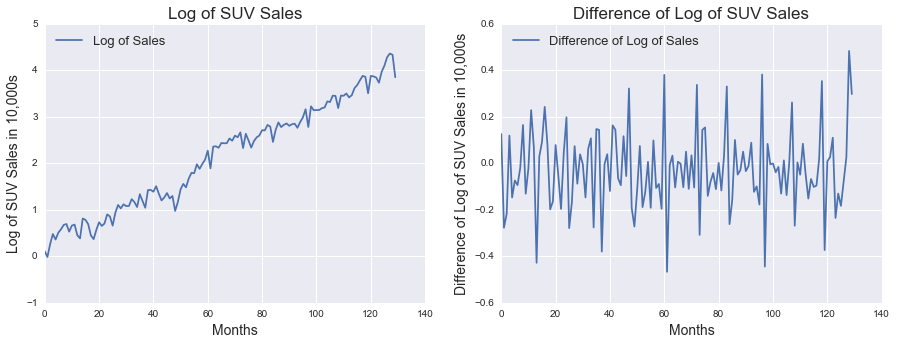

In [8]:
# then plot the log

fig, ax = plt.subplots(figsize = (15,5))

plt.subplot(121)
plt.title('Log of SUV Sales', fontsize = 17)
plt.plot(df.log_sales, label = 'Log of Sales')
plt.xlabel('Months', fontsize = 14)
plt.ylabel('Log of SUV Sales in 10,000s', fontsize = 14)
plt.legend(loc = 2, fontsize = 13)

plt.subplot(122)
plt.title('Difference of Log of SUV Sales', fontsize = 17)
plt.plot(df.diff_log_sales, label = 'Difference of Log of Sales')
plt.xlabel('Months', fontsize = 14)
plt.ylabel('Difference of Log of SUV Sales in 10,000s', fontsize =14)
plt.legend(loc = 2, fontsize = 13)

In [9]:
# we still have an increasing mean, so we should now difference the the logs
df['diff_log_sales'] = df.log_sales - df.log_sales.shift(periods=-1)
df.loc[129,'diff_log_sales'] = (47.02/76.23)*.483182
df.tail()
df.tail()

,End Date,Month,Day,Year,sales,date,log_sales,diff_log_sales
125,10/31/15,10,31,2015,60.23,2015-10-31,4.098171,-0.183068
126,11/30/15,11,30,2015,72.33,2015-11-30,4.281239,-0.079053
127,12/31/15,12,31,2015,78.28,2015-12-31,4.360292,0.026537
128,1/31/16,1,31,2016,76.23,2016-01-31,4.333755,0.483182
129,2/29/16,2,29,2016,47.02,2016-02-29,3.850573,0.298035


In [10]:
df.to_csv('diff_log_sales.csv')

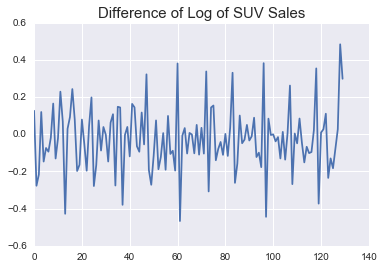

In [11]:
plt.title('Difference of Log of SUV Sales', fontsize = 15)
plt.plot(df.diff_log_sales)

In [12]:
# but we still have obvious seasonality, which we need to remove
# to do this, we will subtract the monthly average of the difference of the log of total sales
# we cheated and extracted the month, day, and year using excel. oops :)
# month = df.diff_log_sales.groupby(df.Month).mean()
# month
df.diff_log_sales.dropna(inplace = True)

In [13]:
# let's open up the seasonally adjusted data set
df = pd.read_csv('diff_log_sales2.csv')
df.head()

,Unnamed: 0,End Date,Month,Day,Year,sales,date,log_sales,diff_log_sales,season_adjust,use_this
0,0,1/31/05,1,31,2005,1.1173,1/31/05,0.110915,0.125826,0.189932,-0.064107
1,1,2/28/05,2,28,2005,0.9852,2/28/05,-0.014911,-0.277198,-0.279618,0.002420
2,2,3/31/05,3,31,2005,1.2999,3/31/05,0.262287,-0.216862,-0.015058,-0.201804
3,3,4/30/05,4,30,2005,1.6147,4/30/05,0.479149,0.119170,0.044785,0.074385
4,4,5/31/05,5,31,2005,1.4333,5/31/05,0.359979,-0.147079,-0.054743,-0.092336


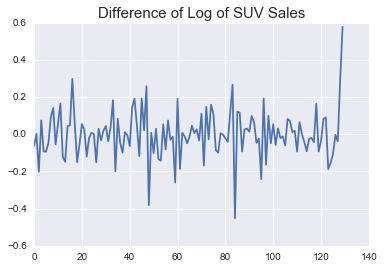

In [14]:
plt.title('Difference of Log of SUV Sales', fontsize = 15)
plt.plot(df.use_this)

In [15]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(df.use_this, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -1.239338e+01
p-value                        4.734145e-23
# Lags Used                    0.000000e+00
Number of Observations Used    1.290000e+02
Critical Value (5%)           -2.884219e+00
Critical Value (1%)           -3.482088e+00
Critical Value (10%)          -2.578864e+00
dtype: float64


In [16]:
df.use_this.dropna()

0     -0.064107
1      0.002420
2     -0.201804
3      0.074385
4     -0.092336
5     -0.093827
6     -0.046654
7      0.090343
8      0.140718
9     -0.054782
10     0.054392
11     0.164478
12    -0.122065
13    -0.148143
14     0.044136
15     0.047342
16     0.297509
17     0.059555
18    -0.150581
19    -0.055037
20     0.054637
21     0.024172
22    -0.120381
23    -0.020041
24     0.007814
25     0.000781
26    -0.151026
27     0.029086
28    -0.033119
29     0.018892
         ...   
100    0.053882
101   -0.058126
102    0.031621
103   -0.021065
104   -0.011507
105   -0.060877
106    0.081986
107    0.071511
108    0.011208
109    0.018852
110   -0.093922
111    0.064541
112    0.000438
113   -0.042237
114   -0.091715
115   -0.025759
116   -0.019694
117   -0.043018
118    0.163765
119   -0.093498
120   -0.035853
121    0.081383
122    0.090473
123   -0.187902
124   -0.154249
125   -0.107069
126   -0.003086
127   -0.037758
128    0.293250
129    0.577653
Name: use_this, dtype: f

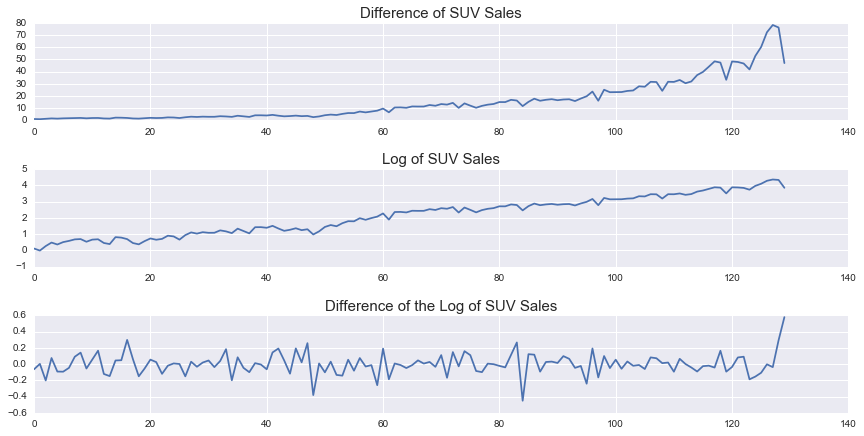

In [17]:
fig, ax = plt.subplots(figsize = (12,6))
fig.tight_layout()
subplots_adjust(hspace = 0.5)

plt.subplot(311)
plt.title('Difference of SUV Sales', fontsize = 15)
plt.plot(df.sales)

plt.subplot(312)
plt.title('Log of SUV Sales', fontsize = 15)
plt.plot(df.log_sales)

plt.subplot(313)
plt.title('Difference of the Log of SUV Sales', fontsize = 15)
plt.plot(df.use_this)

In [18]:
# set column we want to analyze
x = df.sales
y = df.log_sales
z = df.use_this

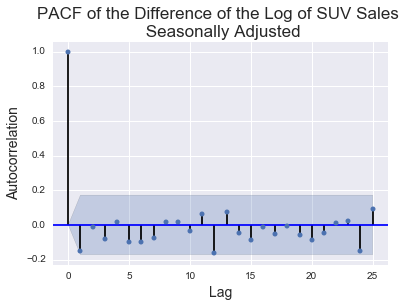

In [19]:
# plot PACF

# plot_pacf(x, lags = 25)
# plt.xlabel('Autocorrelation', fontsize = 15)
# plt.ylabel('Lag', fontsize = 15)
# plt.title('PACF of SUV Sales', fontsize = 18)

# plot_pacf(y, lags = 25)
# plt.xlabel('Autocorrelation', fontsize = 15)
# plt.ylabel('Lag', fontsize = 15)
# plt.title('PACF of the Log of SUV Sales', fontsize = 18)

plot_pacf(z, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of the Difference of the Log of SUV Sales \n Seasonally Adjusted', fontsize = 17)

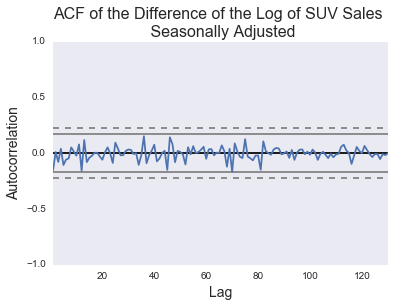

In [20]:
# then we'll do the autocorrelation plot
autocorrelation_plot(z)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of the Difference of the Log of SUV Sales \n Seasonally Adjusted', fontsize= 16)

In [21]:
ararray = (df['use_this'].dropna().as_matrix())

p=0
q=0
d=0
pdq=[]
aic=[]

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                model = ARIMA(ararray, (p,d,q)).fit()
                x = model.aic
                x1 = (p,d,q)
            
                print (x1, x)
                aic.append(x)
                pdq.append(x1)
            except:
                pass
            
            
keys = pdq
values = aic
d = dict(zip(keys, values))
print (d)

((0, 0, 0), -159.82160667324388)
((0, 0, 1), -161.71176796242054)
((0, 0, 2), -160.02612370341222)
((0, 0, 3), -160.43211855262751)
((0, 0, 4), -158.61605213125875)
((0, 0, 5), -160.9004626474129)
((0, 0, 6), -161.79353557388293)
((0, 1, 0), -59.110410643682002)
((0, 1, 1), -151.28557956379115)
((0, 2, 0), 88.637513098289901)
((0, 2, 1), -50.937553901468846)
((1, 0, 0), -161.3824325252544)
((1, 0, 1), -168.1308990170665)
((1, 1, 0), -109.97100651652994)
((1, 1, 1), -152.52216655861713)
((1, 1, 2), -154.91712576395042)
((1, 1, 3), -149.56126684959207)
((1, 1, 4), -147.6094246235039)
((1, 2, 0), -9.339470313053766)
((1, 2, 3), -132.29685915190328)
((2, 0, 0), -159.54924806559706)
((2, 0, 1), -166.62494732648582)
((2, 0, 2), -164.73393355038496)
((2, 0, 3), -163.3207218976524)
((2, 1, 0), -120.6126678905307)
((2, 1, 1), -150.5991242938539)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((2, 1, 2), -149.34231181771878)
((2, 1, 3), -147.2728601386156)
((2, 1, 4), -146.6073704837268)
((2, 2, 0), -41.427418854425184)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((2, 2, 3), -133.95500712385962)
((3, 0, 0), -158.87901212622518)
((3, 0, 1), -156.9702180073064)
((3, 0, 2), -162.74713626210945)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((3, 0, 3), -162.44425343265317)
((3, 1, 0), -130.42248409587046)
((3, 1, 1), -149.5963999470917)
((3, 1, 2), -147.76952241774376)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((3, 1, 3), -149.57237834419874)
((3, 1, 4), -143.34524314097354)
((3, 2, 0), -72.67482338423662)
((3, 2, 1), -120.00448632093469)
((3, 2, 2), nan)
((4, 0, 0), -156.87901340095715)
((4, 0, 1), -163.00260918049247)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((4, 0, 2), -161.38134365962918)
((4, 0, 3), -159.34870001774271)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((4, 0, 4), -158.7861990342206)
((4, 1, 0), -130.215193357891)
((4, 1, 1), -147.6217030183456)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((4, 1, 3), -145.33635334109334)
((4, 2, 0), -87.74964032041066)
((4, 2, 1), -119.51281110958155)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((4, 2, 2), -117.04237596905324)
((4, 2, 3), -129.24167366700385)
((5, 0, 0), -156.63710308893923)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((5, 0, 1), -161.7102756386559)
((5, 0, 2), -159.62619449320954)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((5, 0, 3), -157.8108855168419)
((5, 0, 4), -156.7361440222292)
((5, 1, 0), -129.40062506784574)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((5, 1, 1), -146.34438744640732)
((5, 1, 2), -144.61511637180143)
((5, 1, 3), nan)
((5, 2, 0), -94.84177990488314)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((5, 2, 1), -118.40373323180313)
((5, 2, 2), -115.8732341579393)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((5, 2, 3), -114.20631072241565)
((5, 2, 4), nan)
((6, 0, 0), -156.6933041950644)
((6, 0, 1), -155.68597743261677)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((6, 0, 2), -154.38256967660988)
((6, 0, 3), -153.6482179102839)
((6, 0, 4), nan)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((6, 0, 5), -152.33136699793505)
((6, 0, 6), -150.3347546775363)
((6, 1, 0), -128.96241341162323)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((6, 1, 1), -146.6887323092987)
((6, 1, 2), -145.30324580851885)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



((6, 1, 3), -144.502682295159)
((6, 2, 0), -95.08485836406066)
((6, 2, 1), -115.91186383617253)
{(3, 0, 2): -162.74713626210945, (0, 1, 1): -151.28557956379115, (4, 2, 2): -117.04237596905324, (3, 0, 3): -162.44425343265317, (1, 0, 0): -161.3824325252544, (5, 0, 4): -156.7361440222292, (6, 0, 1): -155.68597743261677, (5, 2, 0): -94.84177990488314, (1, 0, 1): -168.1308990170665, (6, 0, 0): -156.6933041950644, (4, 0, 3): -159.34870001774271, (4, 0, 4): -158.7861990342206, (5, 2, 1): -118.40373323180313, (5, 0, 1): -161.7102756386559, (4, 0, 2): -161.38134365962918, (6, 0, 3): -153.6482179102839, (3, 1, 1): -149.5963999470917, (0, 2, 1): -50.937553901468846, (2, 2, 0): -41.427418854425184, (5, 0, 2): -159.62619449320954, (2, 2, 3): -133.95500712385962, (6, 0, 2): -154.38256967660988, (4, 0, 1): -163.00260918049247, (0, 2, 0): 88.637513098289901, (3, 1, 3): -149.57237834419874, (6, 0, 5): -152.33136699793505, (4, 0, 0): -156.87901340095715, (0, 0, 6): -161.79353557388293, (6, 1, 2): -145.

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print (p,d,q)

(1, 0, 1)


In [23]:
pd.DataFrame(zip(pdq, aic)).to_csv("~/desktop/dailyAIC.csv")

## Using this, we can determine that our time series of SUV sales in China is an ARIMA(1,0,1) model

In [24]:
# then fit it for ARIMA(1,0,1)
sales_array = df.use_this.as_matrix()
model = ARIMA(sales_array, (1,0,1)).fit() 
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  130
Model:                     ARMA(1, 1)   Log Likelihood                  88.065
Method:                       css-mle   S.D. of innovations              0.122
Date:                Sat, 09 Apr 2016   AIC                           -168.131
Time:                        18:58:55   BIC                           -156.661
Sample:                             0   HQIC                          -163.470
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0032      0.001     -2.967      0.004        -0.005    -0.001
ar.L1.y        0.7530      0.065     11.531      0.000         0.625     0.881
ma.L1.y       -1.0000      0.023    -43.314      0.0

In [25]:
import statsmodels.stats.diagnostic
from pypr.stattest.ljungbox import *
import scipy.stats

In [26]:
# predict our ARIMA(5,0,5) model
pred = model.predict()
# then use ljung-box on our prediction
box = statsmodels.stats.diagnostic.acorr_ljungbox(pred, lags=10, boxpierce=False)
box

(array([  74.55841314,  129.53562607,  165.82319852,  192.82279231,
         208.06087922,  217.80556779,  223.31725439,  227.53942232,
         229.95940338,  230.74832527]),
 array([  5.88703527e-18,   7.44211187e-29,   1.01463162e-35,
          1.31121052e-40,   5.35186832e-43,   3.05594290e-44,
          1.30368787e-44,   9.81459375e-45,   1.67797383e-44,
          5.98476964e-44]))

In [27]:
box_test = pd.DataFrame([box[0],box[1]], index = ['Test Result','p-value'])
box_test

,0,1,2,3,4,5,6,7,8,9
Test Result,7.455841e+01,1.295356e+02,1.658232e+02,1.928228e+02,2.080609e+02,2.178056e+02,2.233173e+02,2.275394e+02,2.299594e+02,2.307483e+02
p-value,5.887035e-18,7.442112e-29,1.014632e-35,1.311211e-40,5.351868e-43,3.055943e-44,1.303688e-44,9.814594e-45,1.677974e-44,5.984770e-44


In [28]:
# calculate the residuals (or errors)
prediction = pd.DataFrame(df.use_this.dropna(), columns = ['use_this'])
prediction['predict'] = model.predict()
prediction['residuals'] = prediction.use_this - prediction.predict

In [29]:
prediction['date'] = df['End Date']
prediction.head()

,use_this,predict,residuals,date
0,-0.064107,-0.003181,-0.060925,1/31/05
1,0.002420,0.004342,-0.001923,2/28/05
2,-0.201804,0.002748,-0.204551,3/31/05
3,0.074385,0.031547,0.042838,4/30/05
4,-0.092336,0.016249,-0.108586,5/31/05


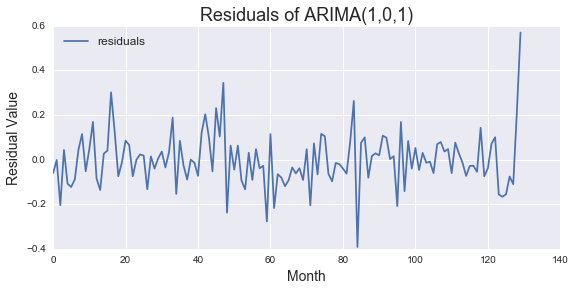

In [30]:
fig, ax = plt.subplots(figsize = (20,4))

plt.subplot(121)
plt.plot(prediction.residuals)
plt.title('Residuals of ARIMA(1,0,1)', fontsize = 18)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Residual Value', fontsize = 14)
plt.legend(loc=2, fontsize = 12)

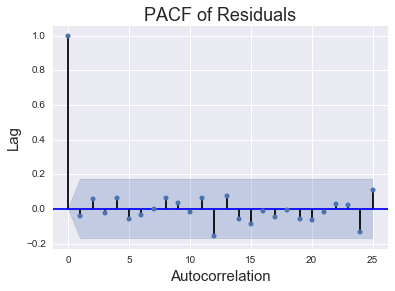

In [31]:
plot_pacf(prediction.residuals, lags = 25)
plt.xlabel('Autocorrelation', fontsize = 15)
plt.ylabel('Lag', fontsize = 15)
plt.title('PACF of Residuals', fontsize = 18)

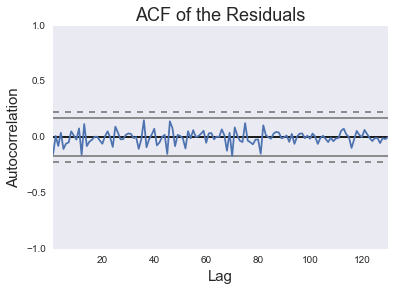

In [32]:
# then we'll do the autocorrelation plot
autocorrelation_plot(z)
plt.xlabel('Lag', fontsize = 15)
plt.ylabel('Autocorrelation', fontsize = 15)
plt.title('ACF of the Residuals', fontsize= 18)

In [33]:
prediction.tail()

,use_this,predict,residuals,date
125,-0.107069,0.048722,-0.155792,10/31/15
126,-0.003086,0.073210,-0.076296,11/30/15
127,-0.037758,0.072618,-0.110376,12/31/15
128,0.293250,0.080341,0.212909,1/31/16
129,0.577653,0.008692,0.568961,2/29/16


In [34]:
numofsteps = 50
predict = model.forecast(numofsteps)[0]
ferrors = model.forecast(numofsteps)[2]

newmonths = pd.date_range(prediction.date.iloc[-1], periods = numofsteps, freq = 'M')
allmonths = pd.date_range(prediction.date[0], periods=30 + len(prediction.date), freq = 'M')

forecasting = pd.DataFrame(ferrors, columns = ['low', 'high'])
forecasting['forecast'] = predict
forecasting['date'] = newmonths

master = prediction.append(forecasting)

In [35]:
master.forecast.astype('string')
master.date = pd.to_datetime(master.date)
master.tail(10)

,date,forecast,high,low,predict,residuals,use_this
40,2019-06-30,-0.003183,0.251198,-0.257563,NaN,NaN,NaN
41,2019-07-31,-0.003182,0.251198,-0.257563,NaN,NaN,NaN
42,2019-08-31,-0.003182,0.251199,-0.257563,NaN,NaN,NaN
43,2019-09-30,-0.003182,0.251199,-0.257563,NaN,NaN,NaN
44,2019-10-31,-0.003182,0.251199,-0.257562,NaN,NaN,NaN
45,2019-11-30,-0.003182,0.251199,-0.257562,NaN,NaN,NaN
46,2019-12-31,-0.003182,0.251199,-0.257562,NaN,NaN,NaN
47,2020-01-31,-0.003181,0.251199,-0.257562,NaN,NaN,NaN
48,2020-02-29,-0.003181,0.251199,-0.257562,NaN,NaN,NaN
49,2020-03-31,-0.003181,0.251199,-0.257562,NaN,NaN,NaN


In [36]:
# # then prepare a dataframe that includes the output of the ljung-box test 
# # we will use this when plotting the actuals, forecast, and confidence intervals on one graph
# df = pd.DataFrame(forecast[2], columns = ['lower','upper'])
# df['forecast'] = forecast[0]
# df['date'] = pd.date_range(data.date.iloc[-1], periods = periods, freq = 'M')
# df

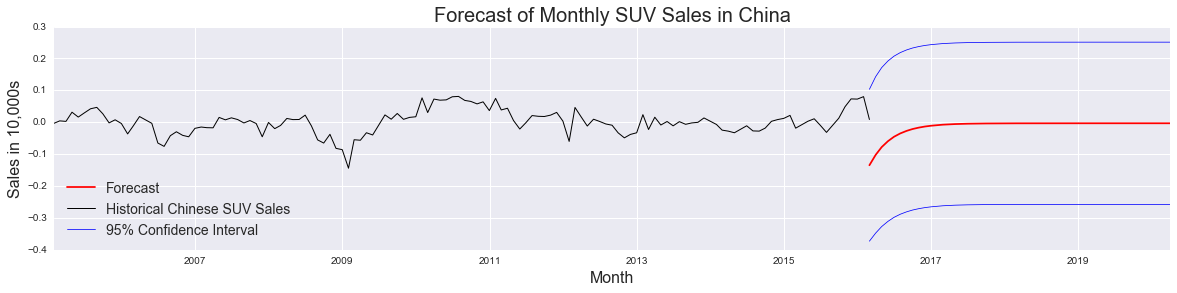

In [37]:
fig, ax = plt.subplots(figsize=(20,4))

plt.plot(master.date, master.forecast, label = "Forecast", c = 'r')
plt.plot(master.date, master.predict, label = 'Historical Chinese SUV Sales', linewidth = 1.0, c = 'k')
plt.plot(master.date, master.high, label = "95% Confidence Interval", linewidth = .75, c = 'b')
plt.plot(master.date, master.low, label = "", linewidth = .75, c = 'b')

plt.title("Forecast of Monthly SUV Sales in China",
             size = 20)
plt.ylabel('Sales in 10,000s', size = 16)
plt.xlabel('Month', size = 16)
plt.legend(loc=3, shadow=True, prop={'size':14})
#plt.xlim([datetime.date(2012,11,1), datetime.date(2013, 2, 28)])

In [38]:
# restate the dataframe so we can better view the forecast
master2 = master[75:]

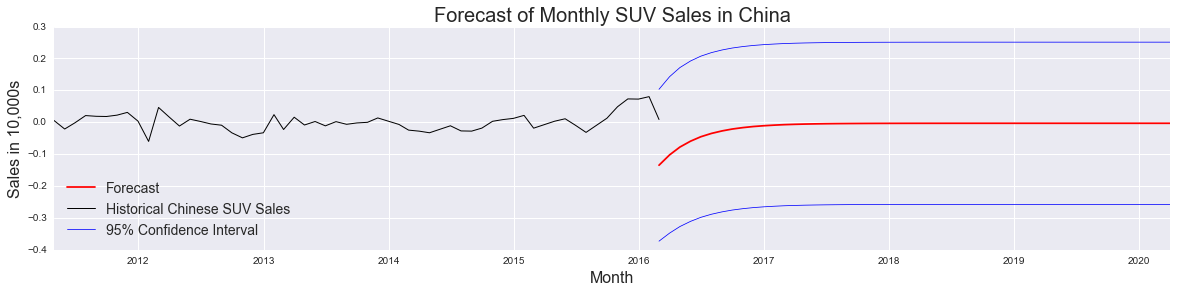

In [39]:
fig, ax = plt.subplots(figsize=(20,4))

plt.plot(master2.date, master2.forecast, label = "Forecast", c = 'r')
plt.plot(master2.date, master2.predict, label = 'Historical Chinese SUV Sales', linewidth = 1.0, c = 'k')
plt.plot(master2.date, master2.high, label = "95% Confidence Interval", linewidth = .75, c = 'b')
plt.plot(master2.date, master2.low, label = "", linewidth = .75, c = 'b')
#plt.plot(newmonths, newforecast.lower, label = "95% Confidence Interveral", c = 'r')
#plt.plot(newmonths, df.LogUn, label = "Actual Data")
plt.title("Forecast of Monthly SUV Sales in China",
             size = 20)
plt.ylabel('Sales in 10,000s', size = 16)
plt.xlabel('Month', size = 16)
plt.legend(loc=3, shadow=True, prop={'size':14})